## ControlNet
This notebooks contains the code to configure and run Stable Diffusion with Canny ControlNet.

Source: [https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/controlnet](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/controlnet)  
Author: [Takuma Mori](https://huggingface.co/takuma104)  
Update: Medya Tekes Mizrakli, Ekaterina Trimbach, Colin Pelletier \\

# Install and import required libaries


In [1]:
!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.0/231.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.3 MB/s eta 0:00:00


In [2]:
import os
import shutil
import torch
import cv2
import PIL
import numpy as np
import pandas as pd

from diffusers import UniPCMultistepScheduler, StableDiffusionControlNetPipeline, ControlNetModel, StableDiffusionInstructPix2PixPipeline
from diffusers.utils import load_image
from PIL import Image

# Import image path
In the cell below, the stylized images path and the corresponding categories are extracted. The categories are further used in Stable Diffusion prompt to provide more information to the model.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
DATA_FOLDER = '/content/drive/MyDrive/VI_DATA/Survey_imgs/content'

In [6]:
 # get the path of stylized, landmark and style images
stylized_images_cropped = os.listdir(DATA_FOLDER)
landmark_images = [img.split('_')[0] for img in stylized_images_cropped]
stylized_images = [DATA_FOLDER + '/' + img for img in stylized_images_cropped]

In [7]:
# import pairs to be able to import categories
pairs = pd.read_csv('/content/drive/MyDrive/VI_DATA/Landmark_imgs/test_ids.csv', index_col='id')
image_categories = pairs.loc[[img for img in landmark_images if 'content' not in img], 'category'].str.replace('_', ' ')
image_categories = pd.concat((image_categories, pd.Series(data={'content0.jpg': 'Gardens of Babylon', 'content1.jpg':'Temple of Artemis'}, name='id')), axis=0)

# Helpers

In [8]:
def extractCannyImage(stylized_image, low_threshold, high_threshold):
    """
        Extract the canny edges of an image.

        stylized_image: numpy.array
            The image for which edges are extracted
        low_threshold: int
            Low canny threshold
        high_threshold: int
            High canny threshold
    """
    stylized_image = cv2.Canny(stylized_image, low_threshold, high_threshold)
    stylized_image = stylized_image[:, :, None]
    stylized_image = np.concatenate([stylized_image, stylized_image, stylized_image], axis=2)
    return Image.fromarray(stylized_image)

def image_grid(imgs, rows, cols):
    """
        Display a list of image

        stylized_image: list[numpy.array]
            The images to display
        rows: int
            Number of rows
        cols: int
            Number of columns
    """
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

# Canny pipeline
The following cell downloads and instanciate the Canny ControlNet and the Stable Diffusion pipeline.

In [9]:
# Import ControlNet and StableDiffusion
cannyControlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", controlnet=cannyControlnet, torch_dtype=torch.float16)

canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)

# setup CPU offloading
canny_pipe.enable_model_cpu_offload()

# use FlashAttention layer for acceleration
canny_pipe.enable_xformers_memory_efficient_attention()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


## Generate images
Generate images using ControlNet and Stable Diffusion

Prompt:  Mount Rushmore National Memorial, realistic, landmark picture
Negative prompt: 


  0%|          | 0/20 [00:00<?, ?it/s]

Prompt:  Sydney Opera House, realistic, landmark picture
Negative prompt: 


  0%|          | 0/20 [00:00<?, ?it/s]

Prompt:  Trevi fountain, realistic, landmark picture
Negative prompt: 


  0%|          | 0/20 [00:00<?, ?it/s]

Prompt:  Angkor Wat, realistic, landmark picture
Negative prompt: 


  0%|          | 0/20 [00:00<?, ?it/s]

Prompt:  Mount Rushmore National Memorial, realistic, landmark picture
Negative prompt: 


  0%|          | 0/20 [00:00<?, ?it/s]

Prompt:  Sydney Opera House, realistic, landmark picture
Negative prompt: 


  0%|          | 0/20 [00:00<?, ?it/s]

Prompt:  Trevi fountain, realistic, landmark picture
Negative prompt: 


  0%|          | 0/20 [00:00<?, ?it/s]

Prompt:  Gardens of Babylon, realistic, landmark picture
Negative prompt: 


  0%|          | 0/20 [00:00<?, ?it/s]

Prompt:  Temple of Artemis, realistic, landmark picture
Negative prompt: 


  0%|          | 0/20 [00:00<?, ?it/s]

Prompt:  Angkor Wat, realistic, landmark picture
Negative prompt: 


  0%|          | 0/20 [00:00<?, ?it/s]

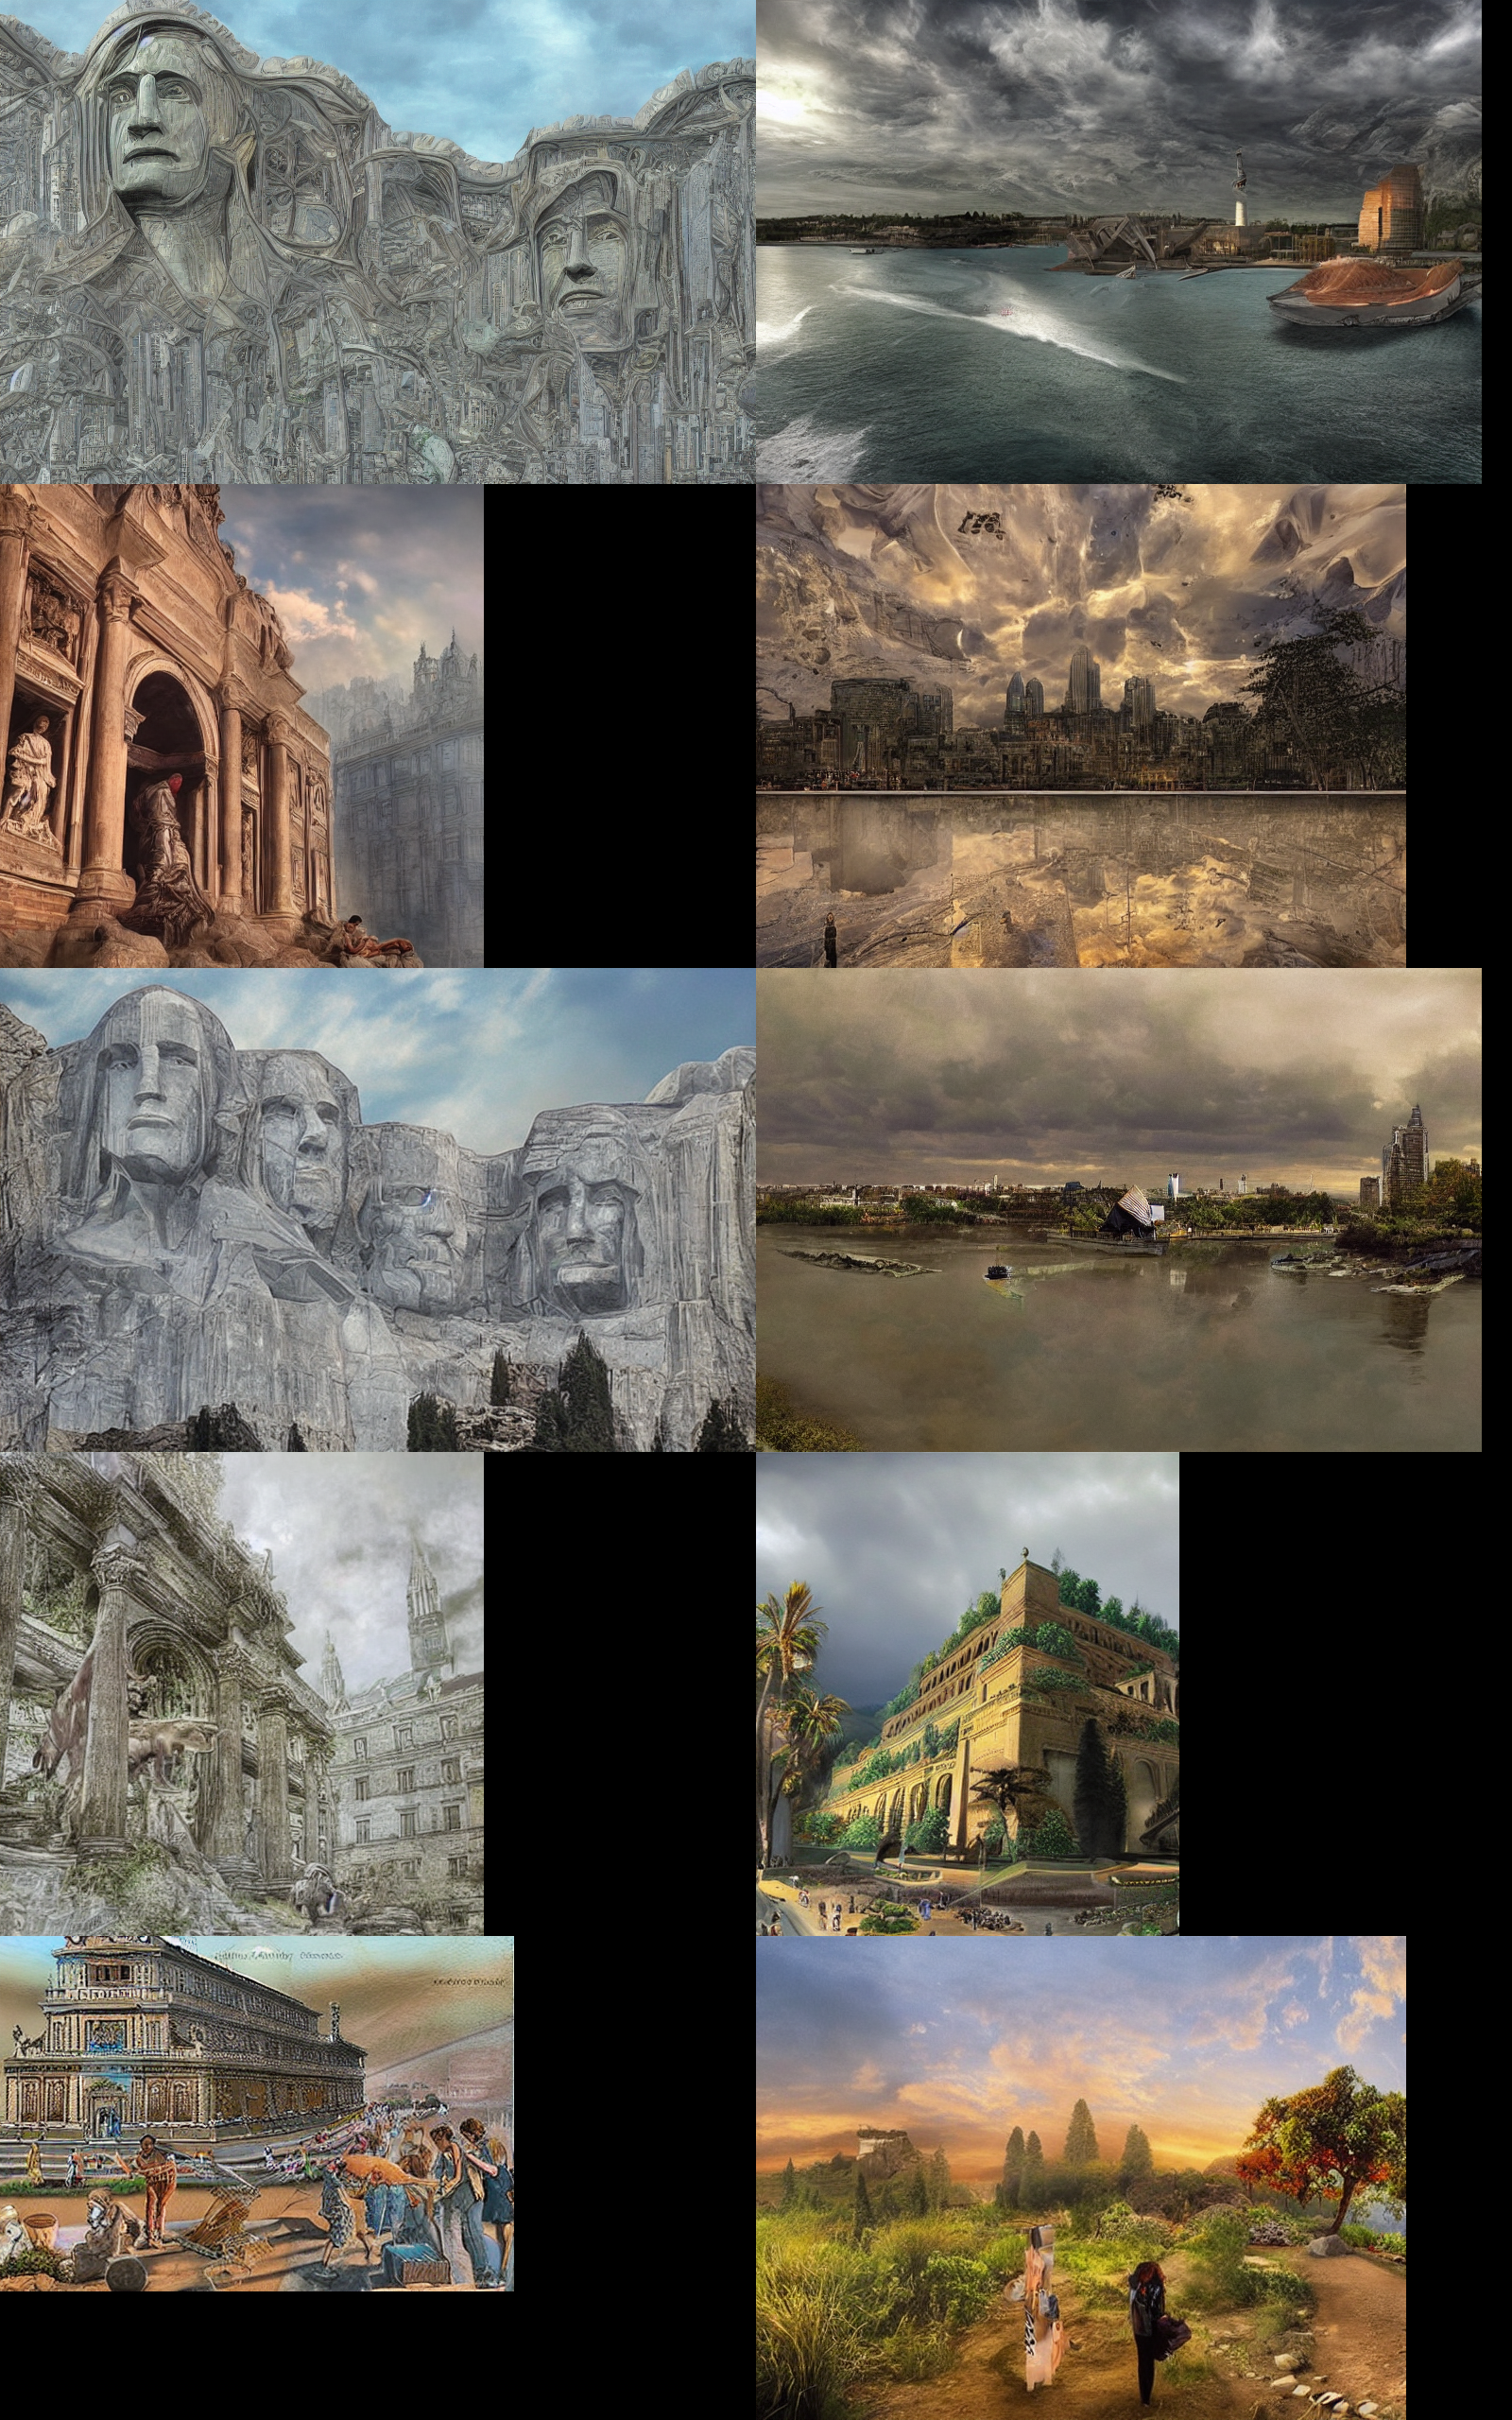

In [15]:
# export folder
output_folder_canny = '/content/drive/MyDrive/VI_DATA/Survey_imgs/SD_canny'

# canny params
low_threshold = 100
high_threshold = 350

# SD input
prompt = ", realistic, landmark picture" 
negative_prompt = ""

# SD params
num_inference_steps = 20 # number of iteration. More iterations generally leads to better quality images
generator = torch.Generator(device="cpu").manual_seed(2) # for consistency of results

output_images = []
for stylized_image, landmark_image in zip(stylized_images, landmark_images):
    # recover the category (i.e. description) of the landmark
    image_category = image_categories.loc[landmark_image]
    if not isinstance(image_category, str):
        image_category = image_category.iloc[0]
    
    image_prompt = image_category + prompt
    print("Prompt: ", image_prompt)
    print("Negative prompt:", negative_prompt)

    # load the image
    stylized_image = load_image(stylized_image)
    stylized_image = np.array(stylized_image)

    # extract edges
    canny_image = extractCannyImage(stylized_image, low_threshold, high_threshold)
        
    # generate image
    sd_output = canny_pipe(
                prompt,
                canny_image,
                negative_prompt=negative_prompt,
                generator=generator,
                num_inference_steps=num_inference_steps,
            ).images[0]
    output_images.append(sd_output)

# show results
image_grid(output_images, 5, 2)

## Export images
Export the images into the defined folder.

In [ ]:
# remove all existing files
import shutil
if os.path.exists(output_folder_canny):
    shutil.rmtree(output_folder_canny)

os.makedirs(output_folder_canny)

# export images
for img_name, output_img in zip(stylized_images, output_images):
    output_img.save(output_folder_canny + '/' + img_name.split('/')[-1])

# Pix2Pix pipeline
We also tried using Pix2Pix ControlNet to modify the content of the image, while keeping the basic structure. This approach was not successfull as the landmark were mostly changed and had stylized effects.

In [ ]:
# define the pipeline
model_id = "timbrooks/instruct-pix2pix"
pix2pix_pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

In [ ]:
output_folder_pix2pix = '/content/drive/MyDrive/VI_DATA/Survey_imgs/SD_pix2pix'

# user input
#prompt = ", realistic, landmark picture, realistic texture, natural color" 
prompt = "Turn this {} stylized image into a realistic picture. Keep the original content" 
negative_prompt = "stylized, painting"

# model params
image_guidance_scale = 1.2 # importance of image
guidance_scale = 11 # importance of textual prompt
num_inference_steps = 15 # number of iteration. More iterations generally leads to better quality images


output_images = []
input_images = []
for stylized_image, landmark_image in zip(stylized_images[:2], landmark_images[:2]):
    image_category = image_categories.loc[landmark_image]
    if not isinstance(image_category, str):
        image_category = image_category.iloc[0]
    
    #image_prompt = image_category + prompt
    image_prompt = prompt.format(image_category)
    print(image_prompt)
    print(negative_prompt)

    # load the image
    stylized_image = load_image(stylized_image)

    # generate image  
    sd_output = pix2pix_pipe(image_prompt, 
                             negative_prompt=negative_prompt,
                             image=stylized_image, 
                             num_inference_steps=num_inference_steps,
                             image_guidance_scale=image_guidance_scale, 
                             guidance_scale=guidance_scale,).images[0]

    output_images.append(sd_output)


# show results
image_grid(output_images, 1, 2)

In [ ]:
# remove all existing files
import shutil
if os.path.exists(output_folder_pix2pix):
    shutil.rmtree(output_folder_pix2pix)

os.makedirs(output_folder_pix2pix)

# export images
for img_name, output_img in zip(stylized_images, output_images):
    output_img.save(output_folder_pix2pix + '/' + img_name.split('/')[-1])